In [127]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import zscore,iqr
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFE,SelectKBest,f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
import re

In [2]:
ds = pd.read_excel('ml_project1_data.xlsx')
ds.set_index('ID', inplace=True)

### Brief exploration

In [45]:
print(ds.info(), "\nResponse rate: {}%".format(round(100*ds["Response"].mean(), 2)))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2240 entries, 6862 to 8720
Data columns (total 28 columns):
Year_Birth             2240 non-null int64
Education              2240 non-null object
Marital_Status         2240 non-null object
Income                 2216 non-null float64
Kidhome                2240 non-null int64
Teenhome               2240 non-null int64
Dt_Customer            2240 non-null object
Recency                2240 non-null int64
MntWines               2240 non-null int64
MntFruits              2240 non-null int64
MntMeatProducts        2240 non-null int64
MntFishProducts        2240 non-null int64
MntSweetProducts       2240 non-null int64
MntGoldProds           2240 non-null int64
NumDealsPurchases      2240 non-null int64
NumWebPurchases        2240 non-null int64
NumCatalogPurchases    2240 non-null int64
NumStorePurchases      2240 non-null int64
NumWebVisitsMonth      2240 non-null int64
AcceptedCmp3           2240 non-null int64
AcceptedCmp4           22

In [46]:
ds.describe()

,Year_Birth,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
count,2240.000000,2216.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,...,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.0,2240.0,2240.000000
mean,1968.805804,52247.251354,0.444196,0.506250,49.109375,303.935714,26.302232,166.950000,37.525446,27.062946,...,5.316518,0.072768,0.074554,0.072768,0.064286,0.013393,0.009375,3.0,11.0,0.149107
std,11.984069,25173.076661,0.538398,0.544538,28.962453,336.597393,39.773434,225.715373,54.628979,41.280498,...,2.426645,0.259813,0.262728,0.259813,0.245316,0.114976,0.096391,0.0,0.0,0.356274
min,1893.000000,1730.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0,0.000000
25%,1959.000000,35303.000000,0.000000,0.000000,24.000000,23.750000,1.000000,16.000000,3.000000,1.000000,...,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0,0.000000
50%,1970.000000,51381.500000,0.000000,0.000000,49.000000,173.500000,8.000000,67.000000,12.000000,8.000000,...,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0,0.000000
75%,1977.000000,68522.000000,1.000000,1.000000,74.000000,504.250000,33.000000,232.000000,50.000000,33.000000,...,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0,0.000000
max,1996.000000,666666.000000,2.000000,2.000000,99.000000,1493.000000,199.000000,1725.000000,259.000000,263.000000,...,20.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.0,11.0,1.000000


## Removing duplicates

In [3]:
"""Nós temos dois tipos de dados repetidos. Dados repetidos com o Response diferente e dados repetidos com o Response
igual. O que significa que temos de ter cuidado, porque têm de ser tratados de maneira diferente
Primeiramente vamos eliminar os dados que estão repetidos com Response diferente. No máximo temos 3 casos repetidos,
pelo que tendo 2 para 1, não representa uma diferença significativamente grande para ficar com 1 individuo do grupo que 
tem mais. Depois, com os dados que ficamos, vamos ver os que têm duplicados, e neste caso vamos ficar sempre com 
um deles. Por default, o primeiro que aparece."""

ds = pd.read_excel("ml_project1_data.xlsx")
ds = ds.drop(columns=["ID","Response"])
da = pd.read_excel("ml_project1_data.xlsx").fillna(-1)

#Colunas do dataset numa lista e retirar a primeira, aka ID
colunas = list(da)
colunas.pop(0)

#Obter o count e a lista com os ID's dos repetidos com o target.
target_count = da.groupby(colunas)['ID'].count()
target_list = da.groupby(colunas)['ID'].apply(list)
target = pd.concat([target_count, target_list], axis=1)
target.columns = ['count', 'lista']

#Obter o count e a lista com os ID's dos repetidos sem o target.
no_target_count = da.groupby(list(ds))['ID'].count()
no_target_list = da.groupby(list(ds))['ID'].apply(list)
no_target = pd.concat([no_target_count, no_target_list], axis=1)
no_target.columns = ['count', 'lista']

## Comparar os resultados do "com target" e do "sem target" e fazer a intersecção dos mesmos. Porque se estão iguais 
## nos dois lados, significa que nunca há casos em que os Response são diferentes.
no_target_set = set(map(tuple, no_target.lista))
target_set = set(map(tuple, target.lista))
id_intercept=no_target_set.intersection(target_set)
id_intercept = list(id_intercept)

#Juntar os ID's numa lista para depois ficar apenas com estes casos
ids = []
for i in id_intercept:
    for j in i:
        ids.append(j)
        
#Fiz isto para evitar perder os IDS, usando um merge atraves do index
frame = pd.read_excel("ml_project1_data.xlsx")
frame = frame.loc[frame['ID'].isin(ids)]
sem_ID = frame.drop(columns=["ID"])
sem_ID = sem_ID.drop_duplicates(keep="first")
frame_ID = frame["ID"]
merged = sem_ID.merge(frame_ID.to_frame(), left_index=True, right_index=True, how='inner')
merged.index=merged['ID']


In [4]:
ds=merged.drop(columns='ID').copy()
del merged


#Turning dates into date type:
ds.Dt_Customer=pd.to_datetime(ds['Dt_Customer'].str.replace('-',''),format='%Y%m%d',errors='ignore')

In [5]:
#Duplicate Removal Check
t = ds.drop_duplicates()

len(t) == len(ds)

True

## Exploring missing values

In [7]:
def missing_values_reporter(df):    
    na_count = df.isna().sum() 
    ser = na_count[na_count > 0]
    return pd.DataFrame({"N missings": ser, "p missings": ser.divide(df.shape[0])})

rm_df_miss = missing_values_reporter(ds)

if rm_df_miss.shape[0]==0:
    print("No missing!")
else:
    print('we have',rm_df_miss.iloc[0,0],' missings')
    ds.dropna(inplace=True)

No missing!


# Detecting outliers:

In [15]:
#For analysis porpouses, we must first treat the Dt_customer variable.
#Let's take a look at it first:

np.unique(ds.Dt_Customer.dt.year)

#As we can see , there are only 3 different years, so we wont get much discrimination there! Hence, we choose to 
# alter the Dt_Customer variale to num_days_customer (for number of days customer)

array([2012, 2013, 2014], dtype=int64)

In [8]:
import datetime
now = datetime.datetime.now()
ds['Dt_Customer']=now-ds['Dt_Customer']
ds.Dt_Customer=ds.Dt_Customer.map(lambda x: x.days)

In [9]:
ds.rename(columns={'Dt_Customer':'num_days_customer'},inplace=True)

In [10]:
y = ds['Response']
X = ds.drop(columns = 'Response')
ds, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

ds['Response'] = y_train
X_test['Response'] = y_test

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


## Univariate prespective:

Getting the indexes (idx) for categorical/dummy and numerical variables:

In [19]:
ds.columns

Index(['Year_Birth', 'Education', 'Marital_Status', 'Income', 'Kidhome',
       'Teenhome', 'num_days_customer', 'Recency', 'MntWines', 'MntFruits',
       'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
       'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1',
       'AcceptedCmp2', 'Complain', 'Z_CostContact', 'Z_Revenue', 'Response'],
      dtype='object')

In [15]:
cat_vars=['Education','Marital_Status','AcceptedCmp3','AcceptedCmp4','AcceptedCmp5',
                'AcceptedCmp1', 'AcceptedCmp2','Complain','Response'] 

numerical_var=['Year_Birth','Kidhome','Teenhome','Income','num_days_customer','Recency','MntWines','MntFruits','MntMeatProducts','MntFishProducts',
              'MntSweetProducts','MntGoldProds','NumDealsPurchases','NumWebPurchases','NumCatalogPurchases','NumStorePurchases',
              'NumWebVisitsMonth', 'Response']

In [21]:
#Separating between numerical and categorical variables:
num_ds=ds[numerical_var]
cat_ds=ds[cat_vars]

In [22]:
len(numerical_var)

18

Numerical overview:

<Figure size 432x288 with 0 Axes>

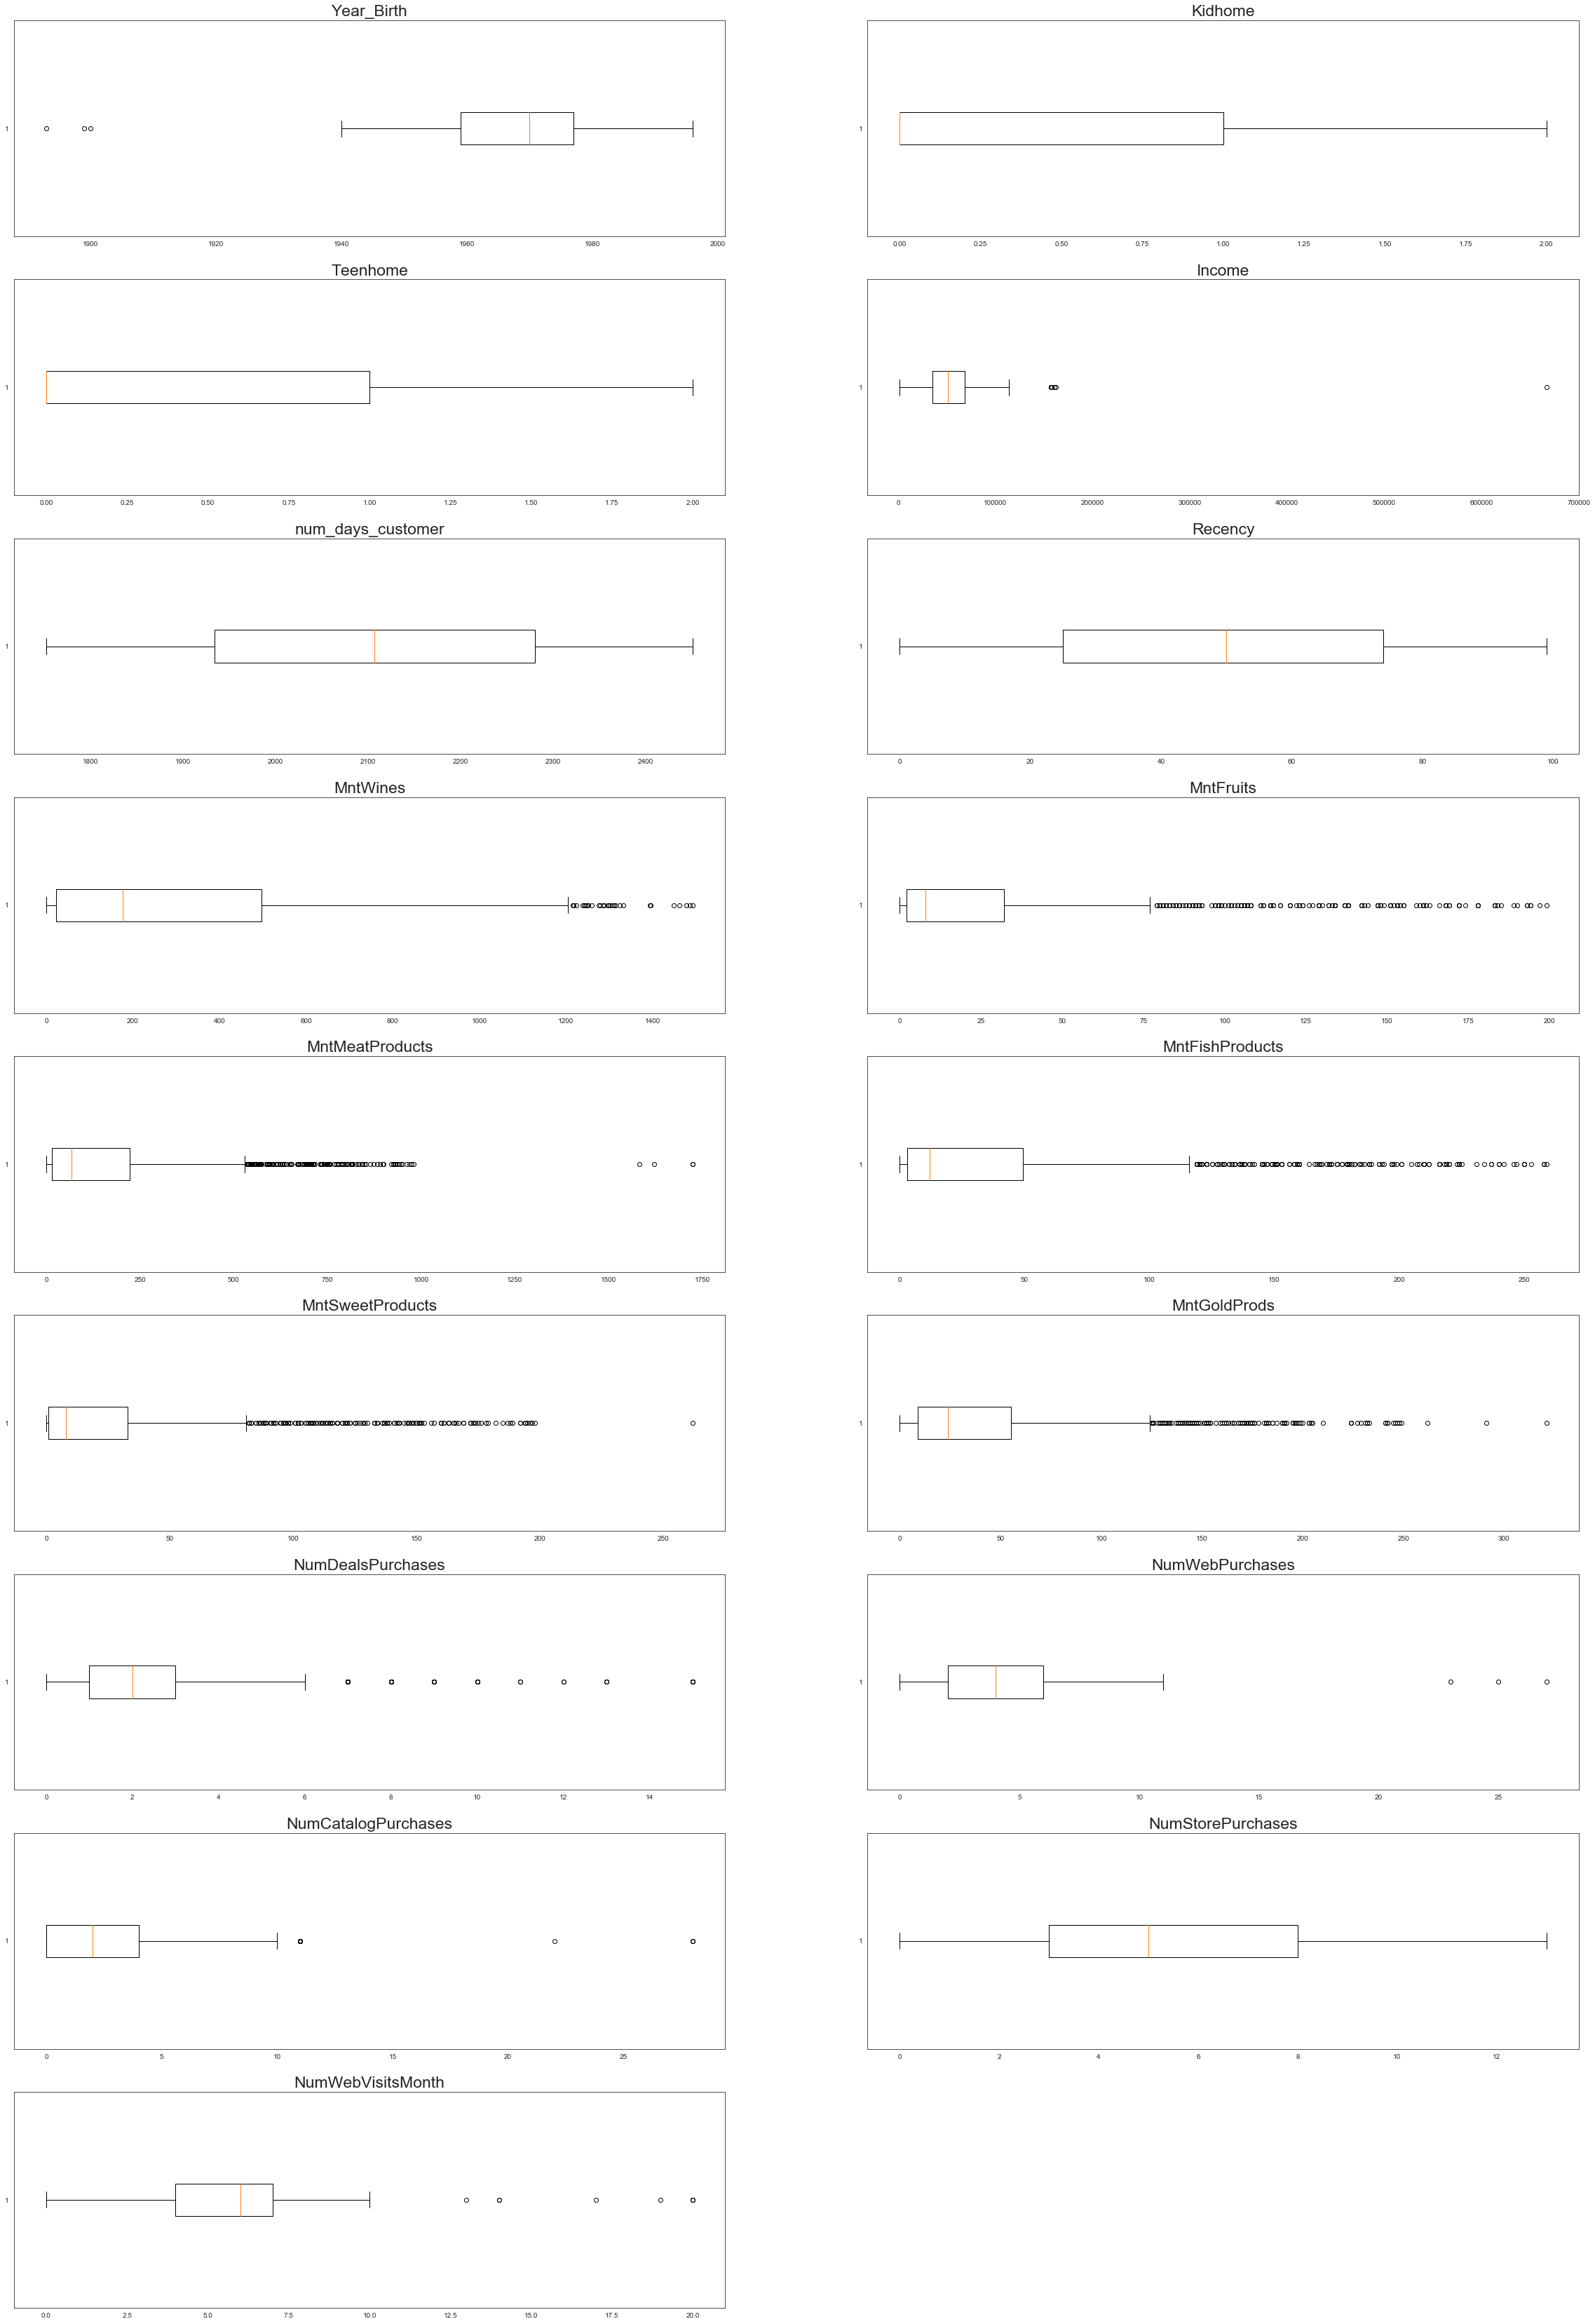

In [23]:
fig = plt.figure()
plt.figure(figsize=(40,60))
sb.set_style("white")
for i in range(1,len(numerical_var)):
    plt.subplot(9, 2, i)
    plt.title(num_ds.columns[i-1],fontsize=23)
    plt.boxplot(num_ds.iloc[:,i-1],vert=False)

In [24]:
#Year_birth
ds = ds[(ds['Year_Birth']>1920)]

#KidHome (no outliers)

#TeenHome (no outliers)

#Income
ds = ds[ds['Income']<153920]

#num_days_customer (no outliers)

#MntWines (??? maybe no outliers)

#MntFruits (??? maybe no outliers)

#MntMeatProducts
ds = ds[ds['MntMeatProducts']<1500]

#MntFishProducts (??? maybe no outliers)

#MntSweetProducts
ds = ds[ds['MntSweetProducts']<250]

#MntGoldProds
ds = ds[ds['MntGoldProds']<290]

#NumDealsPurchases
ds = ds[ds['NumDealsPurchases']<14] #74 rows deleted

#NumWebPurchases
ds = ds[ds['NumWebPurchases']<23] # 3 rows deleted

#NumCatalogPurchases ???
ds = ds[ds['NumCatalogPurchases']<21]

#NumStorePurchases 

#NumWebVisitsMonth
ds = ds[ds['NumWebVisitsMonth']<13]

In [25]:
scaler = MinMaxScaler()
temp = pd.DataFrame(scaler.fit_transform(ds[numerical_var]), columns = numerical_var)

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\sklearn\preprocessing\data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [26]:
temp2 = pd.DataFrame()
var= 'NumCatalogPurchases'
temp2['norm'] = temp[var].sort_values(ascending=False).head(300).values
temp2['no_norm'] = ds[var].sort_values(ascending=False).head(300).values
temp2

,norm,no_norm
0,1.000000,11
1,1.000000,11
2,1.000000,11
3,1.000000,11
4,1.000000,11
5,1.000000,11
6,1.000000,11
7,1.000000,11
8,1.000000,11
9,1.000000,11


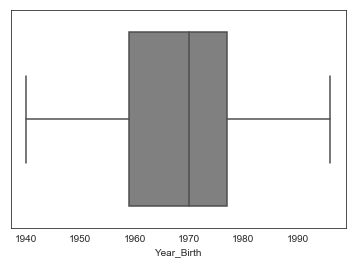

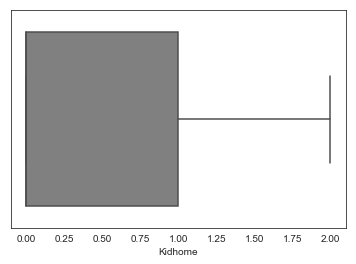

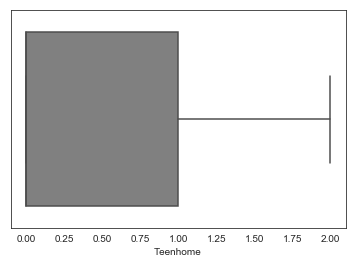

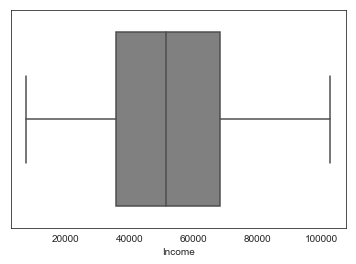

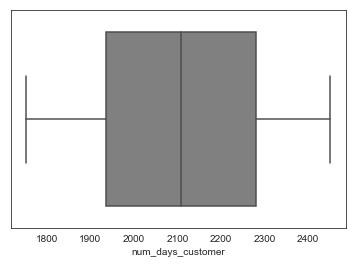

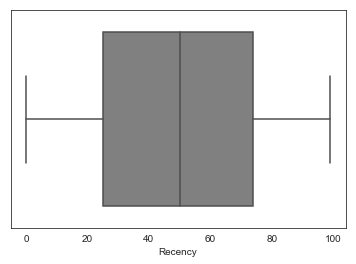

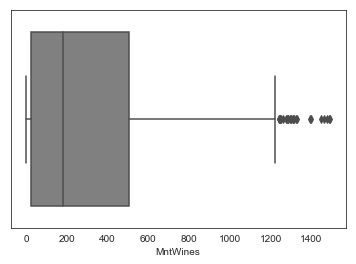

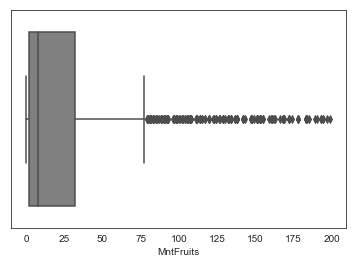

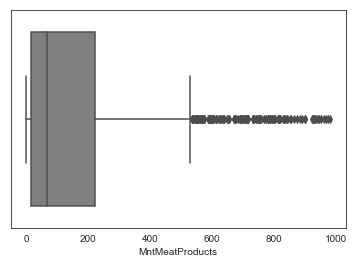

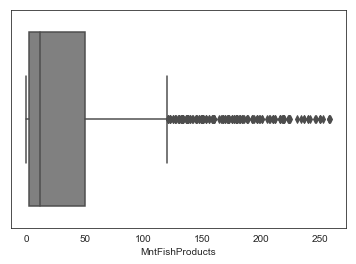

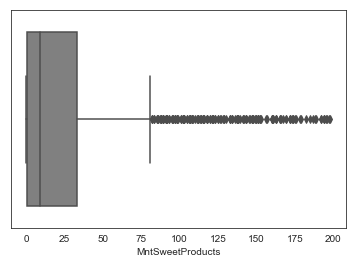

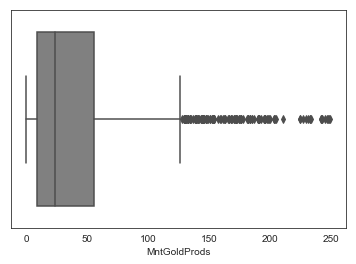

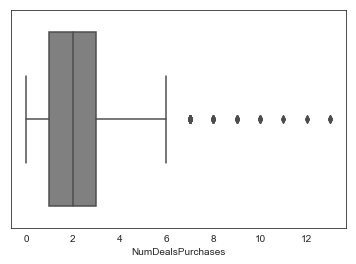

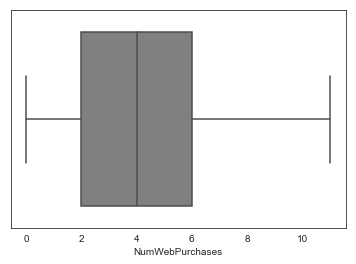

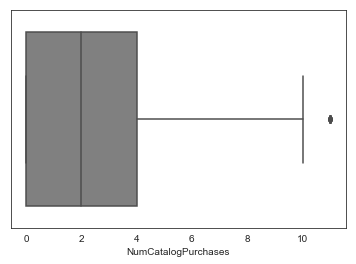

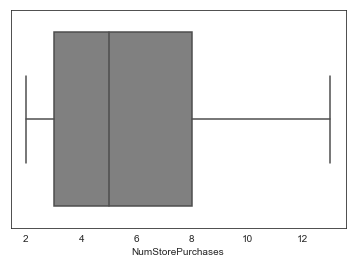

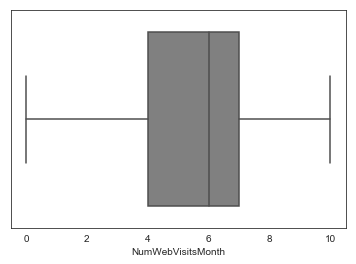

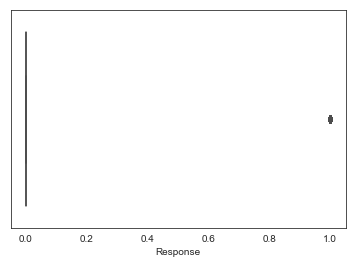

In [27]:
for var in numerical_var:
    plt.figure()
    sb.boxplot(ds[var],color='grey')

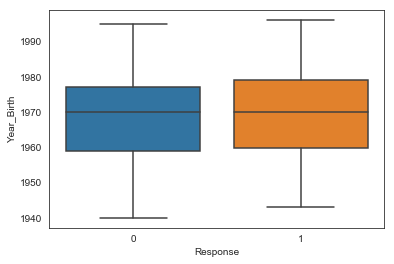

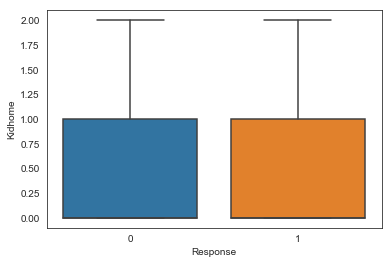

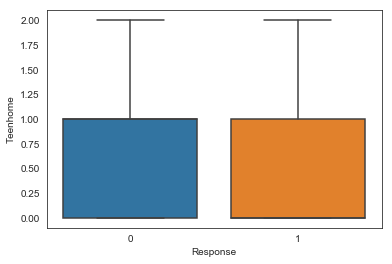

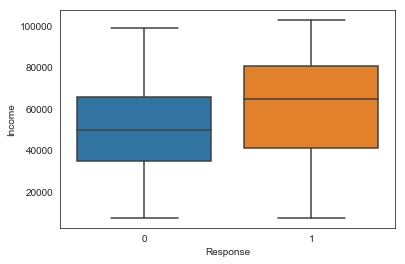

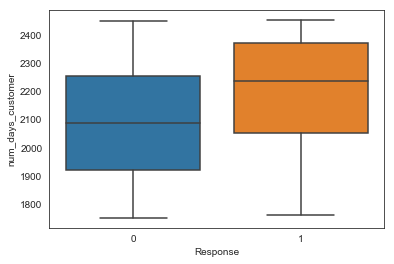

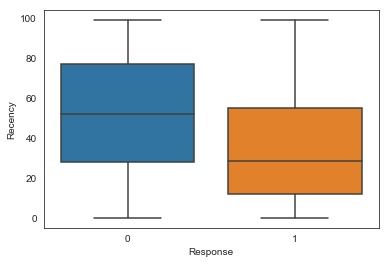

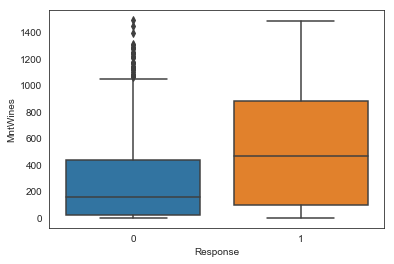

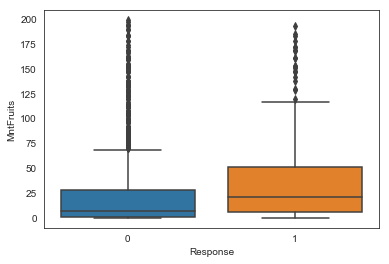

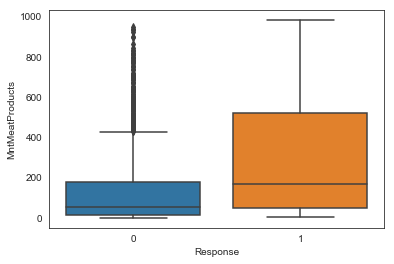

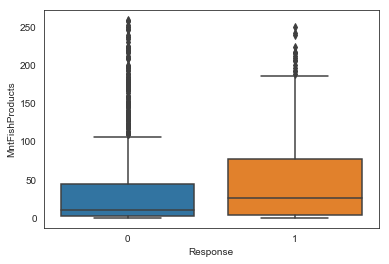

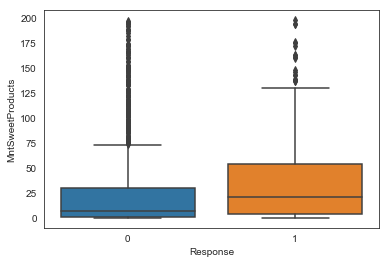

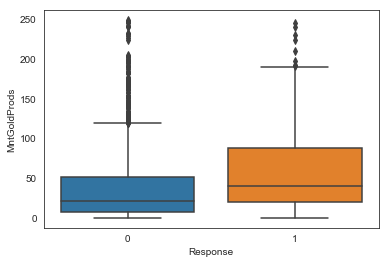

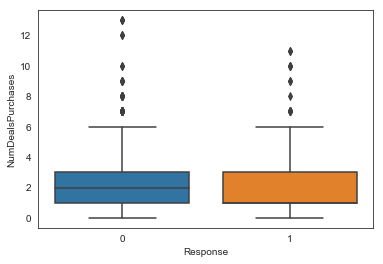

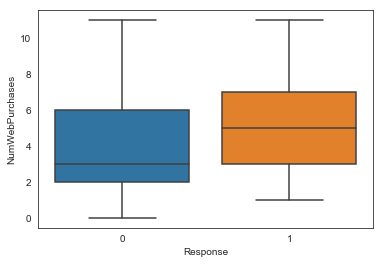

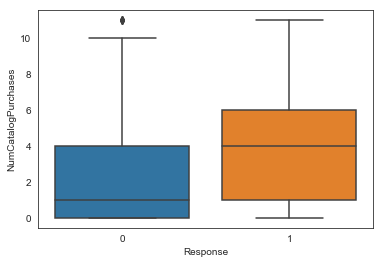

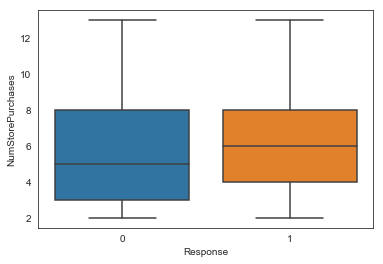

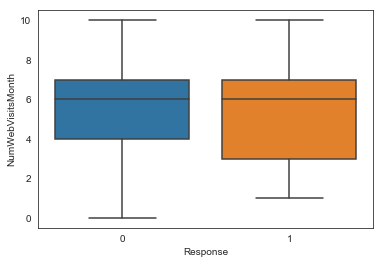

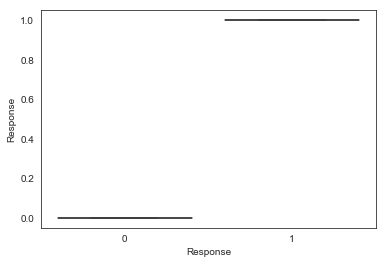

In [28]:
for var in numerical_var:
    plt.figure()
    sb.boxplot(x='Response',y=var,data=ds)

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


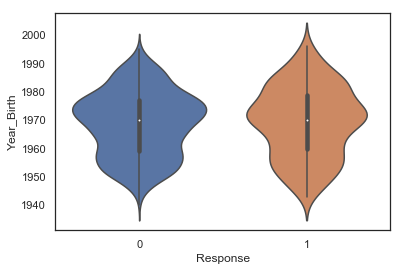

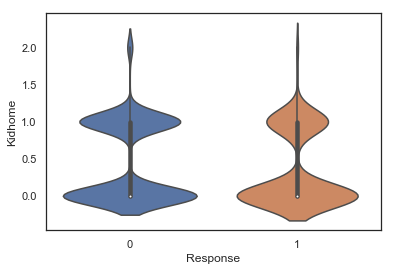

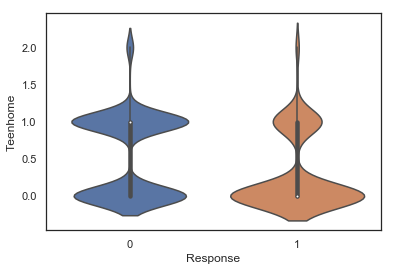

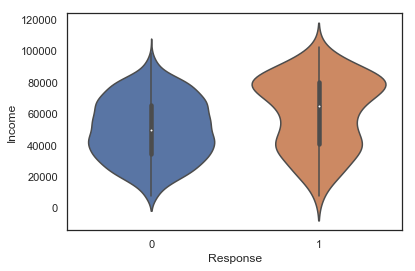

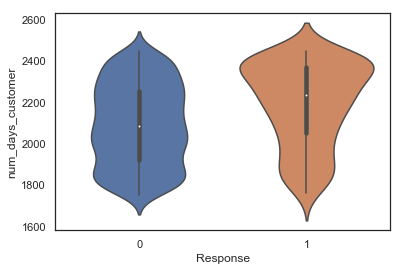

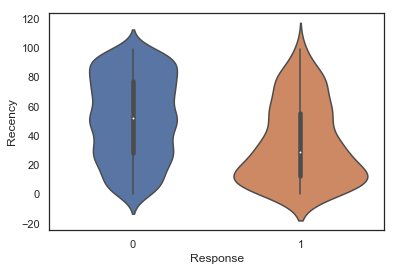

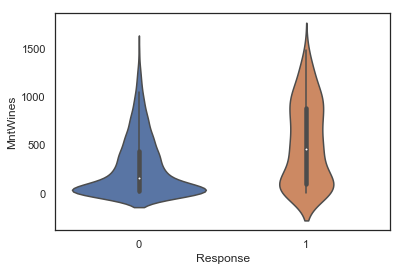

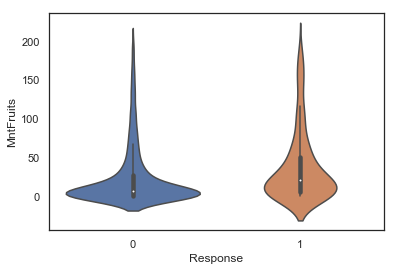

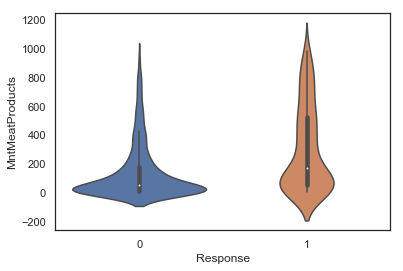

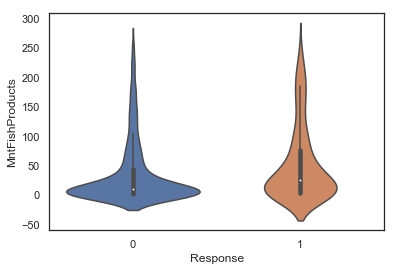

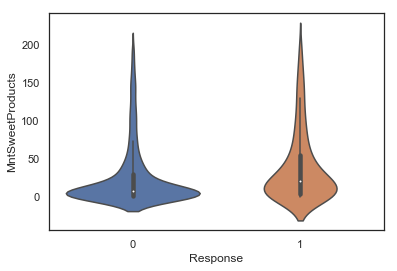

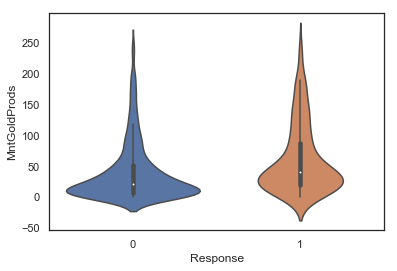

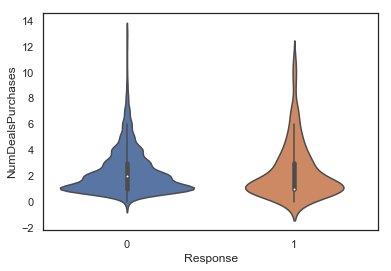

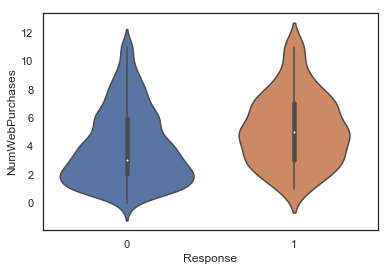

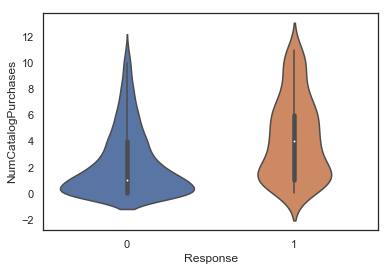

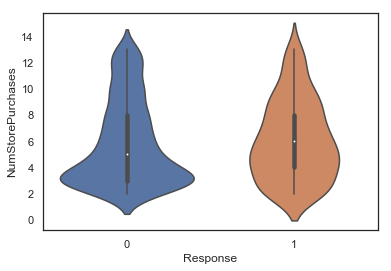

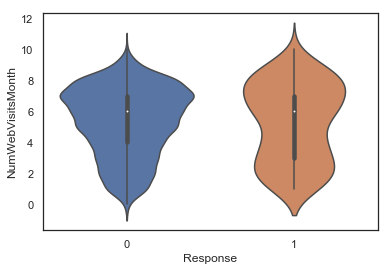

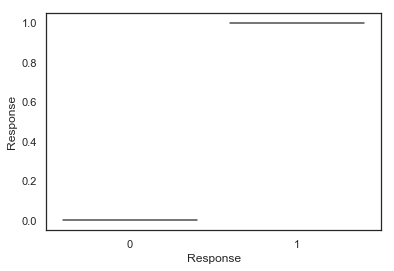

In [374]:
for var in numerical_var:
    plt.figure()
    sb.violinplot(x='Response',y=var,data=ds)

Categorical overview:

<Figure size 432x288 with 0 Axes>

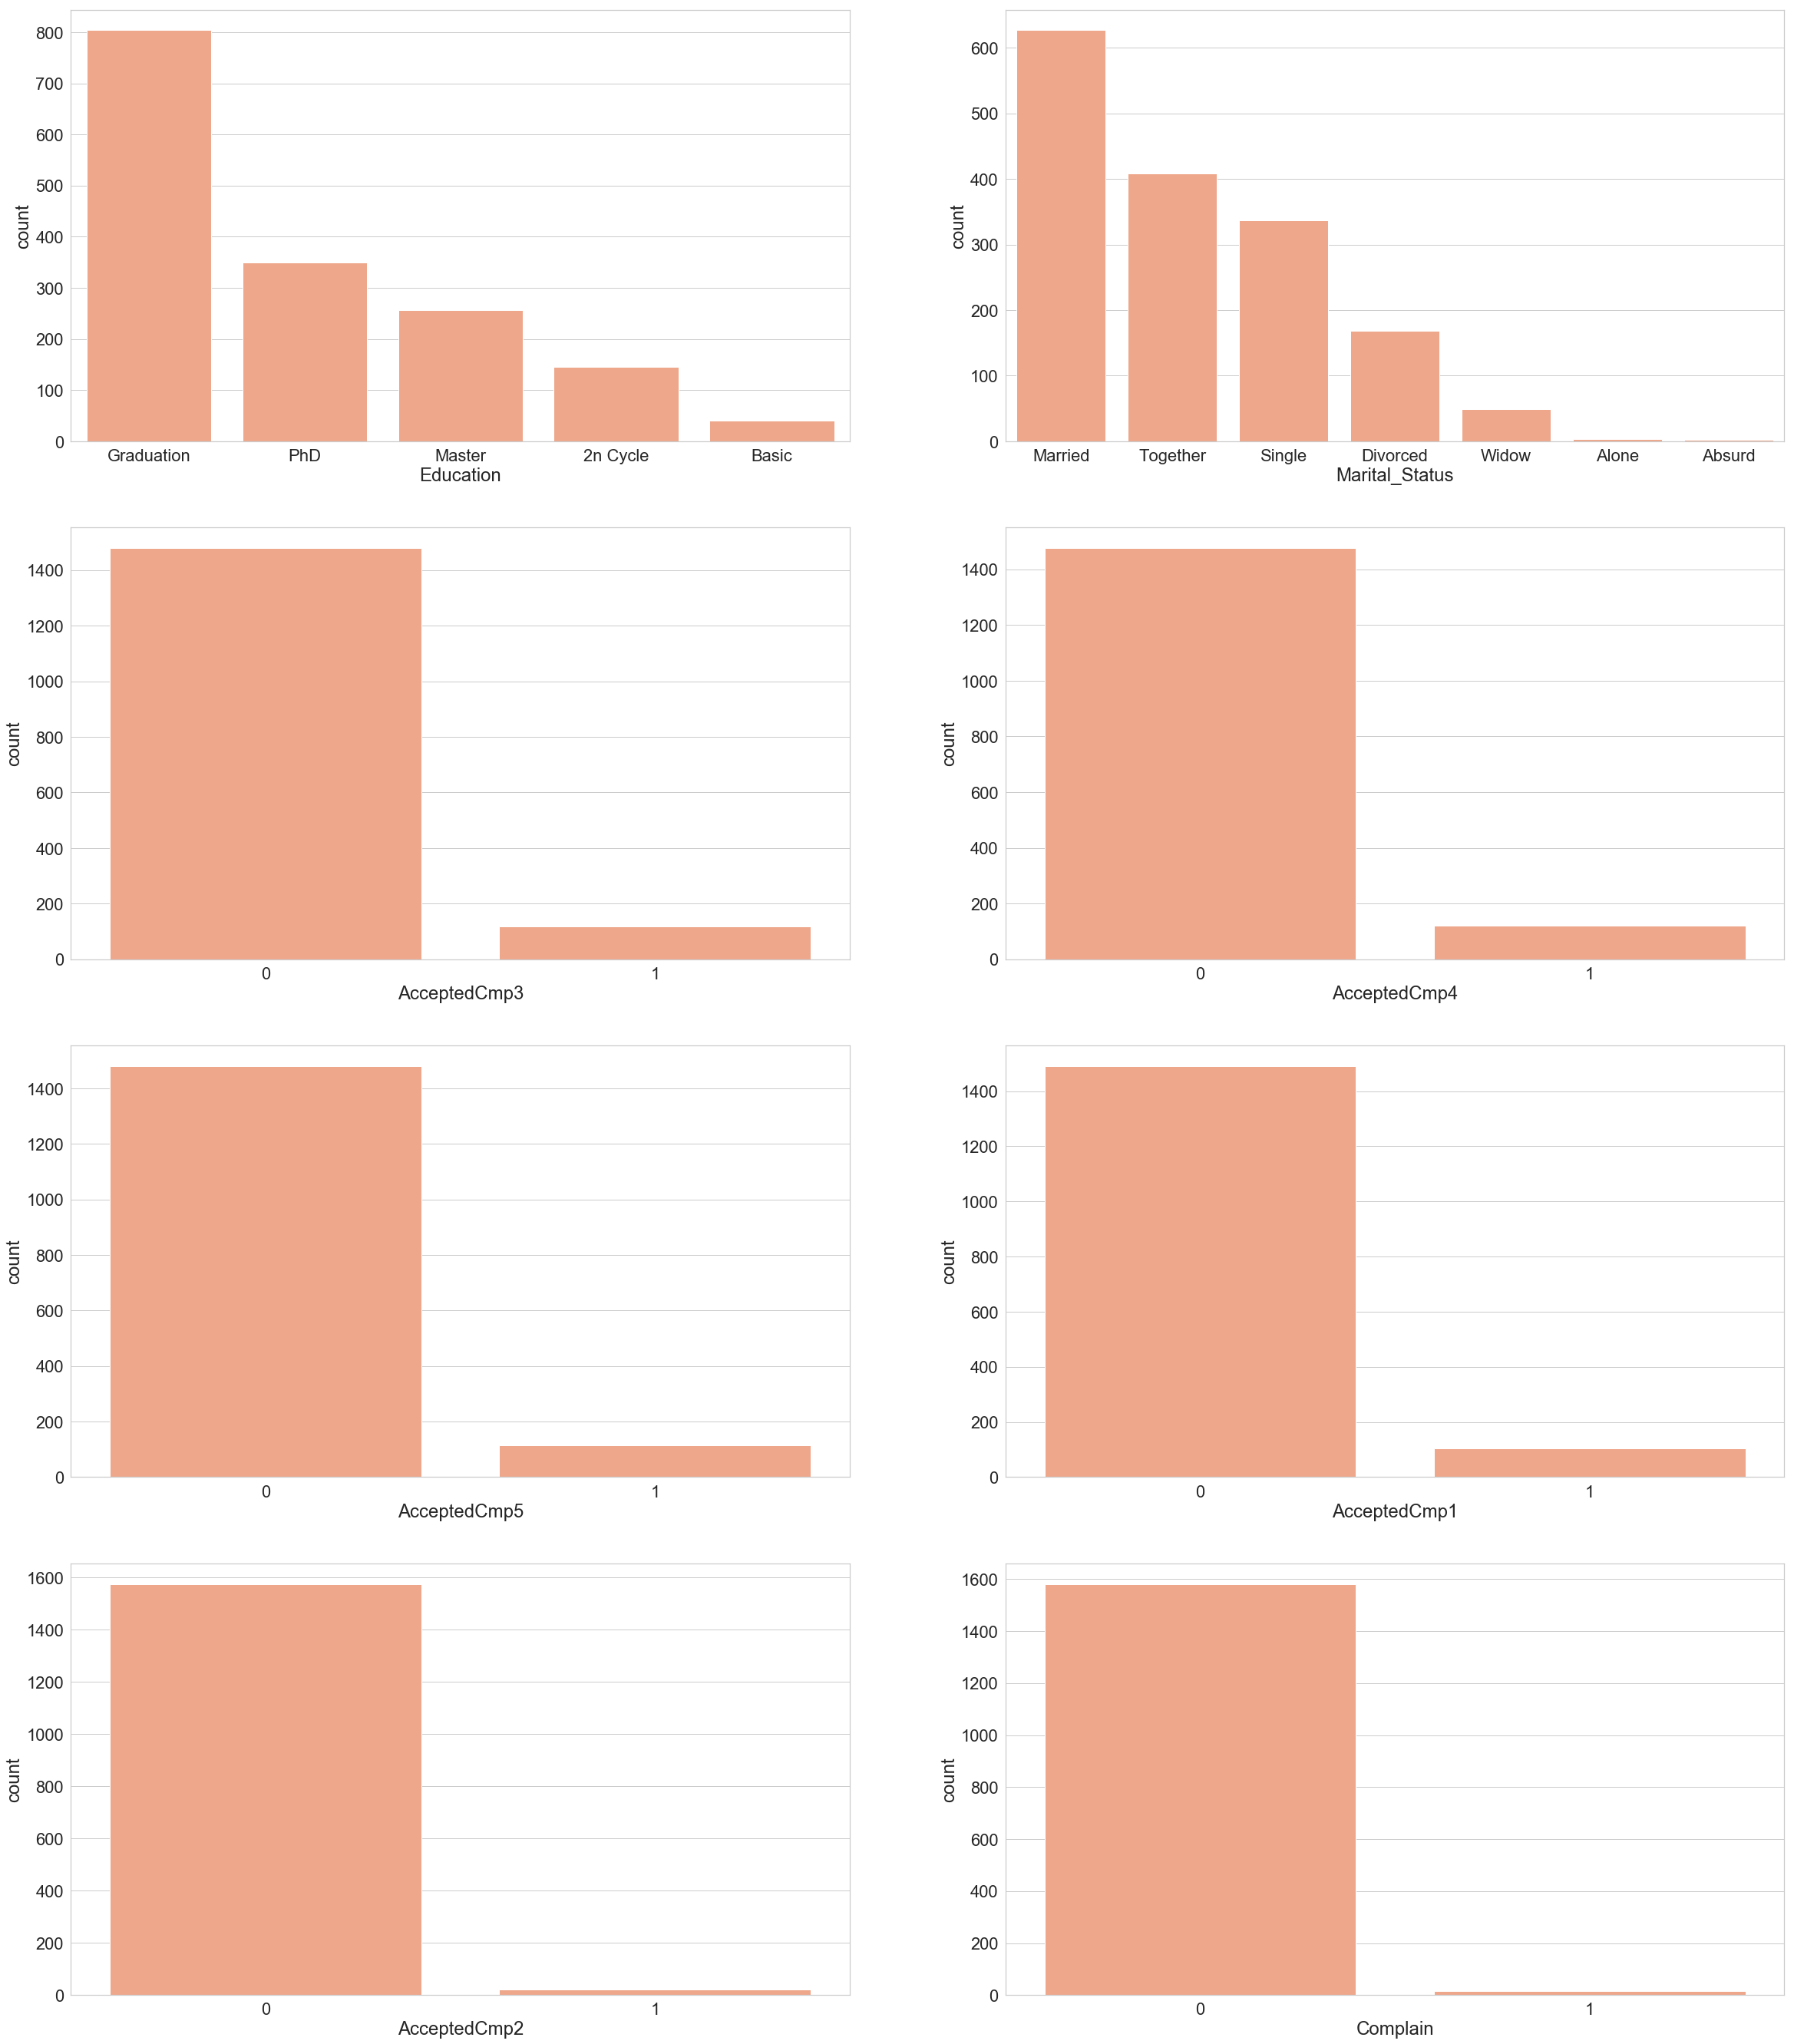

In [29]:
fig = plt.figure()
plt.figure(figsize=(40,60))
sb.set(font_scale=2)
sb.set_style("whitegrid")
for i in range(1,len(cat_vars)):
    plt.subplot(5, 2, i)
    sb.countplot(cat_ds.iloc[:,i-1],color='lightsalmon')


In [30]:
absurd = ["Absurd", "Alone"]
ds = ds.loc[~ds['Marital_Status'].isin(absurd)]

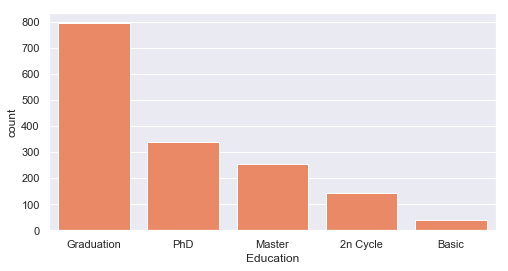

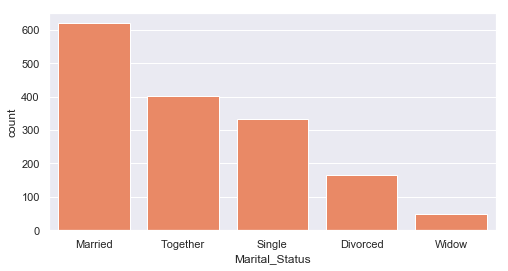

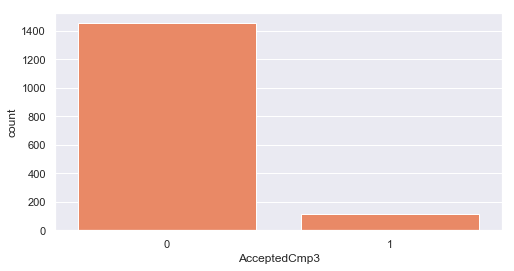

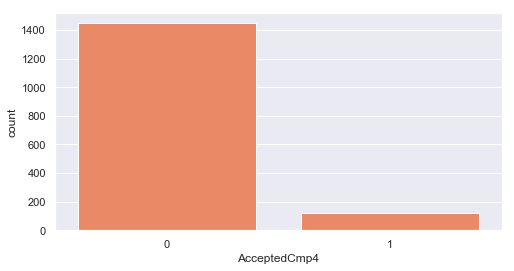

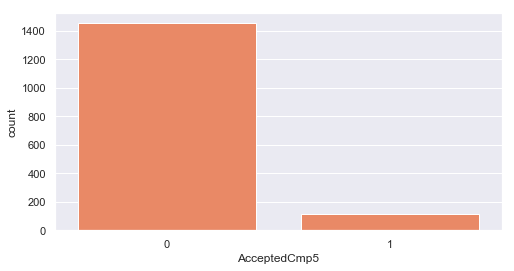

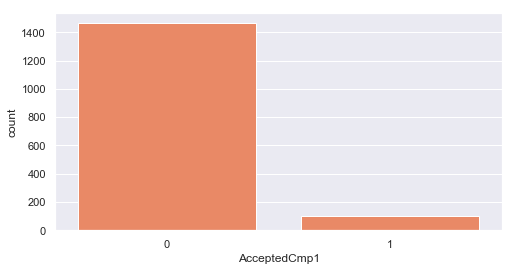

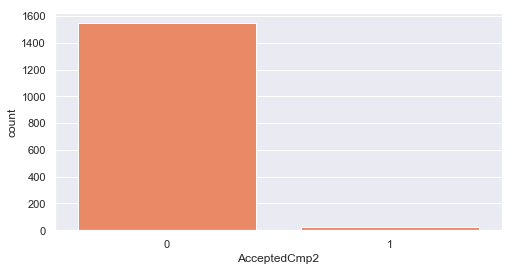

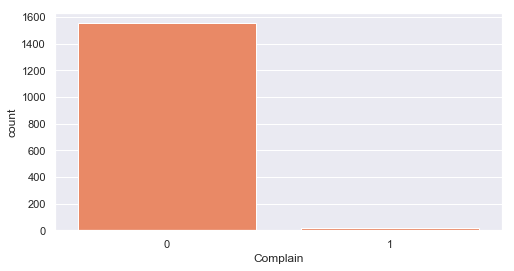

In [31]:
sb.set(font_scale=1)
for var in cat_ds.drop(columns='Response').columns:
    plt.figure(figsize=(8,4))
    sb.countplot(ds[var],color='coral')


#### Fazer boxplot por categoria com hue response.

In [378]:
def z_score_outlier_detection(data,numericals,treshold):
    df=pd.DataFrame(zscore(data[numericals]),columns=numericals)
    df.index=data.index
    temp=np.sum(df>treshold,axis=1)
    my_outliers=temp[temp>0].index
    temp=np.sum(df<-treshold,axis=1)
    my_outliers.append(temp[temp>0].index)
    
    return np.unique(my_outliers)
    
    

In [379]:
def boxplot_outlier_detection(data,numericals):
    box_plot_outliers=[]
    for var in numerical_var:
        df=pd.Series(zscore(data[var]))
        df.index=data.index
        for record in df.index:
            if df[df.index==record].iloc[0]>1.5*iqr(df):
                if record not in box_plot_outliers:
                    box_plot_outliers.append(record)

    return box_plot_outliers

In [380]:
def Robust_z_score_method(df,numerical,treshold):
    df=df[numerical]
    med=df.median()
    MAD=[np.median(np.abs(ds[var]-ds[var].median())) for var in df]
    df=0.6745*(df-df.median())/MAD
    pd.options.mode.use_inf_as_na = True
    df=df.fillna(0)
    def RZ_outliers():
        outliers=np.sum(df>treshold,axis=1)
        return outliers[outliers>0].index
    return df,RZ_outliers()

# Multivariate prespective:

In [95]:
encoded_ds=pd.get_dummies(ds,prefix = ['Edu','mar_status'], drop_first=True)
scaler=MinMaxScaler()
norm_encoded_ds=pd.DataFrame(scaler.fit_transform(encoded_ds),columns=encoded_ds.columns)
norm_encoded_ds.index=encoded_ds.index

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


#### Isolation forest:

In [96]:
from sklearn.ensemble import IsolationForest
from sklearn import metrics
from scipy.stats import multivariate_normal
from sklearn.metrics.pairwise import euclidean_distances
import eif as iso

""" CONTAMINATION: The amount of contamination of the data set, i.e. the proportion of outliers in the data set. 
Used when fitting to define the threshold on the decision function. """
def isolation_forest(ds, contamination):
    clf = IsolationForest(max_samples=100, contamination = contamination, random_state=np.random.RandomState(42))
    clf.fit(ds)
    outliers_isoflorest = clf.predict(ds)
    outliers_isoflorest=pd.Series(outliers_isoflorest)
    outliers_isoflorest.index=ds.index
    return outliers_isoflorest[outliers_isoflorest==-1]

## CUIDADO AGAIN COM OS PARAMETROS 
#INSTALAR EIF NO PIP
def extended_isolation_forest(ds):
    if_eif = iso.iForest(norm_encoded_ds.values, ntrees = 100, sample_size = 256, ExtensionLevel = 2)
    anomaly_scores = if_eif.compute_paths(X_in = norm_encoded_ds.values)
    anomaly_scores=pd.Series(anomaly_scores)
    anomaly_scores.index=norm_encoded_ds.index
    anomaly_scores.sort_values(ascending=False,inplace=True)
    return anomaly_scores

ModuleNotFoundError: No module named 'eif'

#### Mahalanobis distance:

In [ ]:
from scipy.spatial.distance import cdist
#Getting the columns (variables) means
def mahalanobis_distance_outlier(ds):  
    var_means=ds.mean(axis=0).values.reshape(1, -1)
    #Getting the inverse of the covariance matrix
    try:
        inv_cov_matrix = np.linalg.inv(np.cov(ds.T))
    except:
        m=np.cov(ds.T)
        i=np.eye(m.shape[0],m.shape[1])
        inv_cov_matrix=np.linalg.lstsq(m, i)[0]
    try:
        np.linalg.cholesky(inv_cov_matrix)
        print("all good")
    except:
        print("WARNING, mahalanobis no good..")
        #REVER ISTO... 
    MDs=cdist(var_means, ds, 'mahalanobis', VI=inv_cov_matrix)
    MDs=pd.Series([distance for sublist in MDs for distance in sublist],index=ds.index)
    
    def find_outliers():
        treshold=3.
        std = np.std(MDs)
        k = treshold * std
        m = np.mean(MDs)
        mahalanobis_outliers = []
        for index in MDs.index:
            if (MDs[index] >=  m + k) or (MDs[index] <= m - k):
                if index not in mahalanobis_outliers:
                    mahalanobis_outliers.append(index)  # index of the outlier
        return np.array(mahalanobis_outliers)
    return find_outliers()

In [ ]:
def plot_mahalanobis_distance_out(MDs,mahalanobis_outliers):
    sb.set_style('ticks')
    fig = plt.figure()
    plt.figure(figsize=(8,5))
    x=MDs.index
    y=MDs
    col=np.where(np.isin(x,mahalanobis_outliers), 'red', 'black')
    plt.scatter(x,y,c=col)
    plt.axhline(np.mean(MDs),ls='--',color='red',linewidth='3.')
    plt.xlabel('Record ID')
    plt.ylabel('Mahalanobis Distance')
    plt.show()

#### DBSCAN

In [ ]:
from sklearn.cluster import DBSCAN

def Dbscan_outlier_detection (ds,minpoints,radius):
    outlier_detection= DBSCAN(
      eps = radius,
      metric="euclidean",
      min_samples = minpoints,
      n_jobs = -1)
    
    clusters = outlier_detection.fit_predict(ds)
    #Seing the number of identified noise (outliers)
    np.sum(clusters==-1)
    #Identifying the outliers:
    clusters=pd.Series(clusters)
    clusters.index=ds.index
    return clusters.sort_values()
    

#### Elliptic Envelope

In [ ]:
from sklearn.covariance import EllipticEnvelope
def elliptic_envelope_out(ds,contamination):
    elliptic = EllipticEnvelope(contamination = contamination)
    elliptic.fit(ds)
    results=elliptic.predict(ds)
    outlier_elliptic=pd.Series(results)
    outlier_elliptic.index=ds.index
    return outlier_elliptic[outlier_elliptic==-1]

#### Local Outlier Factor:

In [ ]:
from sklearn.neighbors import LocalOutlierFactor
def local_outlier_factor(ds,n_neighbors,contamination):
    lof = LocalOutlierFactor(n_neighbors=10, contamination=0.1)
    outiler_lof = lof.fit_predict(ds)
    outiler_lof=pd.Series(outiler_lof)
    outiler_lof.index=ds.index
    return outiler_lof[outiler_lof==-1]

#### One class SVM:

In [ ]:
from sklearn import svm
def one_class_svm(ds):
    oneclasssvm = svm.OneClassSVM()
    oneclasssvm_outliers = oneclasssvm.fit_predict(ds)
    oneclasssvm_outliers=pd.Series(oneclasssvm_outliers)
    oneclasssvm_outliers.index=ds.index
    return oneclasssvm_outliers[oneclasssvm_outliers==-1]


#### Cooks distance:

In [ ]:
import statsmodels.api as sm
def cooks_distance_outlier(df,vd):
    X=df[vd]
    Y=df.drop(columns=vd)
    m = sm.OLS(X,Y).fit()
    infl = m.get_influence()
    sm_fr = infl.summary_frame()
    return sm_fr['cooks_d'].sort_values(ascending=False)

#### K means outlier detection:

In [11]:
from sklearn.cluster import KMeans
def get_k_means_elbow_graph(ds,numerical,min_clust,max_clust):
    km=pd.DataFrame(columns=['num_clusters','inertia'])
    for i in range(min_clust,max_clust):
        kmeans = KMeans(n_clusters=i).fit(num_ds)
        km=km.append({'num_clusters':i,'inertia':kmeans.inertia_},ignore_index=True)
    sb.lineplot(x=km['num_clusters'],y=km['inertia'])
    return

In [12]:
def k_means_outlier_method(ds,numerical,cluster_range):
    dict_={}
    eall={}
    ds=ds[numerical]
    for i in range(cluster_range[0],cluster_range[1],cluster_range[2]):
        kmeans = KMeans(n_clusters=i).fit(ds)
        eall[str(i)]=kmeans.inertia_
    for record in ds.index:
        temp=ds[ds.index!=record]
        for i in range(cluster_range[0],cluster_range[1],cluster_range[2]):
            kmeans = KMeans(n_clusters=i).fit(temp)
            dict_[str(record)+','+str(i)]=kmeans.inertia_
    def return_data_frame():
        k=pd.DataFrame(columns=['ID','num_clusters','inertia'])
        ids=[key.split(',')[0] for key in dict_.keys()]
        nclust=[key.split(',')[1] for key in dict_.keys()]
        vals=[val for val in dict_.values()]
        k['ID']=ids
        k['num_clusters']=nclust
        k['inertia']=vals
        for i in range(cluster_range[0],cluster_range[1],cluster_range[2]):
            k['inertia'][k['num_clusters']==i]=[eall[str(i)]]*k[k['num_clusters']==i].shape[0]-k['inertia'][k['num_clusters']==i]
        
        return k.rename({'inertia':'gain'},inplace=True)
    return return_data_frame()

# Feature Extraction:

### Buisness insights

In [ ]:
ds_new_var = ds.copy()
#TER CUIDADO, CONFIRMAR SE O NUM WEB PURCHASES TB É MENSAL
ds_new_var["Web_Purchases_Per_Visit"] = ds["NumWebPurchases"]/ds["NumWebVisitsMonth"]

ds_new_var["Total_Purchases"] = ds["NumWebPurchases"] + ds["NumCatalogPurchases"] + ds["NumStorePurchases"]

ds_new_var["RatioWebPurchases"] = ds["NumWebPurchases"] / ds_new_var["Total_Purchases"]
ds_new_var["RatioCatalogPurchases"] = ds["NumCatalogPurchases"] / ds_new_var["Total_Purchases"]
ds_new_var["RatioStorePurchases"] = ds["NumStorePurchases"] / ds_new_var["Total_Purchases"]

ds_new_var["Age"] = now.year - ds["Year_Birth"]

ds_new_var["TotalAcceptedCampaigns"] = ds["AcceptedCmp1"] + ds["AcceptedCmp2"] + ds["AcceptedCmp3"] + ds["AcceptedCmp4"] + ds["AcceptedCmp5"]
#Total amount spent
ds_new_var["TotalMoneySpent"] = ds["MntWines"] + ds["MntFruits"] + ds["MntMeatProducts"] + ds["MntFishProducts"] + ds["MntSweetProducts"] + ds["MntGoldProds"]
#Calculating the ratios of money spent per category
ds_new_var["RatioWines"] = ds["MntWines"] / ds_new_var["TotalMoneySpent"]
ds_new_var["RatioFruits"] = ds["MntFruits"] / ds_new_var["TotalMoneySpent"]
ds_new_var["RatioMeatProducts"] = ds["MntMeatProducts"] / ds_new_var["TotalMoneySpent"]
ds_new_var["RatioFishProducts"] = ds["MntFishProducts"] / ds_new_var["TotalMoneySpent"]
ds_new_var["RatioSweetProducts"] = ds["MntSweetProducts"] / ds_new_var["TotalMoneySpent"]
ds_new_var["RatioGoldProds"] = ds["MntGoldProds"] / ds_new_var["TotalMoneySpent"]

#Changing income to 2 years
ds_new_var["Income2Years"] = ds["Income"] * 2

#Calculating Effort Rate
ds_new_var["EffortRate"] = ds_new_var["TotalMoneySpent"]/ds_new_var["Income2Years"]

#All kids
ds_new_var["TotalKids"] = ds["Teenhome"] + ds["Kidhome"]

#People per Household
status = ["Together", "Married"]
ds_new_var["Count_Household"] = 0
ds_new_var["Count_Household"].loc[(ds["Marital_Status"].isin(status))] = 2 + ds_new_var["TotalKids"]
ds_new_var["Count_Household"].loc[(~ds["Marital_Status"].isin(status))] = 1 + ds_new_var["TotalKids"]

#Income per person in household
ds_new_var["Income_Per_Person"] = ds_new_var["Income2Years"]/ds_new_var["Count_Household"]
ds_new_var.head(5)

### Logs, Squares & Multiples

In [ ]:
from sklearn.preprocessing import MinMaxScaler
#Temos de mudar isto do drop e dos infinitos i think
ds_new_var_lsm = ds_new_var.drop(columns=["Education", "Marital_Status"])
ds_new_var_lsm = ds_new_var_lsm.replace([np.inf, -np.inf], np.nan)
ds_new_var_lsm = ds_new_var_lsm.fillna(0)
scaler = MinMaxScaler(feature_range=(0, 1), copy=True)
X_01=pd.DataFrame(scaler.fit_transform(ds_new_var_lsm),columns=ds_new_var_lsm.columns)
X_01.index=ds_new_var_lsm.index
from scipy import stats
from sklearn.preprocessing import KBinsDiscretizer

# define a set of transformations
trans_dict = {"x": lambda x: x, "log": np.log, "sqrt": np.sqrt, 
              "exp": np.exp, "**1/4": lambda x: np.power(x, 0.25), 
              "**2": lambda x: np.power(x, 2), "**4": lambda x: np.power(x, 4)}

target = "Response"
best_power_dict = {}
for feature in X_01.columns:
    max_test_value, max_trans, best_power_trans = 0, "", None
    for trans_key, trans_value in trans_dict.items():
        # apply transformation
        feature_trans = trans_value(X_01[feature])
        if trans_key == "log":
            #para evitar infinitos ele transforma em -50. 
            feature_trans.loc[np.isfinite(feature_trans)==False] = -50.
        
        # bin feature
        bindisc = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy="uniform")
        feature_bin = bindisc.fit_transform(feature_trans.values[:, np.newaxis])
        feature_bin = pd.Series(feature_bin[:, 0], index=X_01.index)
        
        # obtain contingency table
        df_ = pd.DataFrame(data={feature: feature_bin, target: X_01[target]})
        cont_tab = pd.crosstab(df_[feature], df_[target], margins = False)        
        
        # compute Chi-Squared
        chi_test_value = stats.chi2_contingency(cont_tab)[0]
        if chi_test_value > max_test_value:
            max_test_value, max_trans, best_power_trans = chi_test_value, trans_key, feature_trans      
            
    best_power_dict[feature] = (max_test_value, max_trans, best_power_trans)
    X_01[feature] = best_power_trans
    
print("The best power transformations:")
for key in best_power_dict:
    print("\t>>>", key, best_power_dict[key][1]) 

X_01.head(3, )    

### LDA

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
def LDA_extraction(ds):
    clf = LinearDiscriminantAnalysis(solver="eigen")
    lda = clf.fit(ds, y)
    lda_ds = lda.transform(ds)
    lda_coef = lda.coef_
    lda_means = lda.means_
    exp_var = lda.explained_variance_ratio_
    return lda_ds,exp_var

### Factor Analysis

In [ ]:
from sklearn.decomposition import FactorAnalysis
def factor_analysis_extraction(ds):
    colunas = list(ds)
    fact = FactorAnalysis().fit(ds)
    fact_ds = fact.transform(ds)
    factor_analysis = pd.DataFrame(fact.components_, columns = colunas)
    return fact_ds,factor_analysis

### Independent Component Analysis

In [ ]:
from sklearn.decomposition import FastICA
def ICA(ds):
    colunas = list(ds)
    ica = FastICA().fit(ds)
    indep_comp = pd.DataFrame(ica.components_, columns = colunas)
    indep_ds = ica.transform(ds)
    return indep_comp,indep_ds


In [ ]:
#PENSAR EM FAZER PCA SOBRE ICA

### PCA




In [ ]:
from sklearn.decomposition import PCA
def PCA_extraction(ds):
    pca = PCA()   
    pca.fit(ds)  
    components=pd.Series(pca.explained_variance_ ,index=range(1,ds.shape[1]+1))    
    components=components*100    
    def plot_PCA():
        sb.set_style('ticks')
        fig, ax = plt.subplots()
        plt.rc('xtick',labelsize=20)
        plt.rc('ytick',labelsize=20)
        fig.set_size_inches(7.7,6)
        plt.xlabel('Component',fontsize=20)
        plt.xscale()
        plt.ylabel('Explained Variance',fontsize=20)
        sb.lineplot(x=components.index,y=components,color='black',linewidth=3)
        plt.show()
    plot_PCA()
    return components


In [ ]:
PCA_extraction(norm_encoded_ds)

# Feature selection:

### importance based on linear regression:

In [167]:
#VER PORQUE ]E QUE NAO DEIXA ADICIONAR UMA CONSTANTE
def linear_regression_selection(df,vd,topx):
    reg_results=pd.DataFrame(columns=['variable','Coef','std_err','adj_R2','pvalue'])

    X=df[vd]
    for var in df.drop(columns=vd).columns:
        Y=df[var]
        model = sm.OLS(X,Y).fit()
        predictions = model.predict(X)
        reg_results=reg_results.append({'variable':var,'Coef':model.params[0],'std_err':model.bse[0],
            'pvalue':model.pvalues[0],'adj_R2':model.rsquared_adj},ignore_index=True)
        reg_results.sort_values(by='adj_R2',inplace=True,ascending=False)

    return np.array(reg_results.head(topx)['variable'].values)

In [75]:
def fisher_score(ds,vd,topx):
    f_score=[]
    num=[]
    den=[]
    for class_ in np.unique(ds[vd]):
        nj=ds[ds[vd]==class_].shape[0]
        uij=ds[ds[vd]==class_].mean()
        ui=ds.mean()
        pij=ds[ds[vd]==class_].var()
        num.append(nj*(uij-ui)**2)
        den.append(nj*pij)
    results=sum(num)/sum(den)
    results.drop(labels='Response',inplace=True)
    results.sort_values(ascending=False,inplace=True)
    return np.array(results.head(topx).index)


In [170]:
def all_inf_gain(ds,vd,topx):   
    def entropy(ds):
        if len(ds.unique())>1:
            p_c1 = ds.mean()
            p_c0 = 1 - p_c1
            return np.sum([-p_c0*np.log2(p_c0), -p_c1*np.log2(p_c1)])
        else:
            return 0
    vars_inf_gain=[]
    best_dict={}
    for var in ds:
        v=np.sort(ds[var].unique())
        dict_gains = {}
        for i in range(0, len(v)-1):
            fbin_i = ds[var] <= v[i]
            _0 = ds[vd][~fbin_i]
            _1 = ds[vd][fbin_i]
            res=entropy(ds[vd]) - ((~fbin_i).mean()*entropy(_0)+fbin_i.mean()*entropy(_1))
            dict_gains[var+"_"+str(v[i])] = res
        vars_inf_gain.append(dict_gains)
    
    best_dict={}
    keys=[key for key in s.keys()]  
    for var in ds.drop(columns=vd):
        r = re.compile(var+'_.*')
        vals=[mydict[x] for x in list(filter(r.match, keys))]
        if vals:
            best_dict[list(mydict.keys())[list(mydict.values()).index(max(vals))]]=max(vals)

    best_dict=dict(sorted(best_dict.items(), key=lambda kv: kv[1], reverse=True))
    return np.array(pd.DataFrame(best_dict, index=[0]).T.head(topx).index)

In [ ]:
def ind_inf_gain(ds,var,vd):
    '''para ser usado no FCBF'''
    v=np.sort(ds[var].unique())
    dict_gains = {}
    
    for i in range(0, len(v)-1):
            fbin_i = ds[var] <= v[i]
            _0 = ds[vd][~fbin_i]
            _1 = ds[vd][fbin_i]
            dict_gains[var+"_"+str(v[i])] = entropy(ds[vd]) - ((~fbin_i).mean()*entropy(_0)+fbin_i.mean()*entropy(_1))
    
    return dict_gains

In [80]:
num_ds=ds[numerical_var]

In [ ]:
def FCBF():
    '''used to avoid redundencies in the feature selection'''
    #HELP! VER H(C)

In [187]:
def recursive_feature_elimination(ds,vd,topx):
    'atencao que ha um parametro que ]e o numero de features que queremos ter... o default ]e metade!'
    X=ds.drop(columns=vd)
    Y=ds[vd]
    model = LogisticRegression()
    rfe = RFE(model,n_features_to_select=topx)
    fit = rfe.fit(X, Y)
    return np.array(ds.drop(columns=vd).columns)[np.array(fit.support_)]


In [188]:
recursive_feature_elimination(num_ds,'Response',3)

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

array(['Teenhome', 'NumWebPurchases', 'NumCatalogPurchases'], dtype=object)

In [311]:
def Anova_F_selection(ds,vd,topx):
    '''again.. aqui ha um k, que ]e o numero de features que queremos ter. Default ele da metade.'''
    X=ds.drop(columns=vd)
    Y=ds[vd]
    sel=SelectKBest(score_func=f_classif)
    sel.fit(X,Y)
    res=dict(zip(ds.drop(columns=vd).columns, sel.scores_))
    res=dict(sorted(res.items(), key=lambda kv: kv[1], reverse=True))
    return np.array(pd.DataFrame(res, index=[0]).T.head(topx).index)

In [309]:
def extra_Trees_Classifier(ds,vd,topx):
    ''' choosing number of features based on their importance'''
    X=ds.drop(columns=vd)
    Y=ds[vd]
    model = ExtraTreesClassifier()
    model.fit(X, Y)
    res=dict(zip(ds.drop(columns=vd).columns, model.feature_importances_))
    res=dict(sorted(res.items(), key=lambda kv: kv[1], reverse=True))
    return np.array(pd.DataFrame(res, index=[0]).T.head(topx).index)

## CHI - SQUARED

In [ ]:
from matplotlib.patches import Rectangle
target_variable = "Response"
for i in range(len(cat_vars)):
    plt.figure(i, figsize=(8, 6))
    plt.title(cat_vars[i])
    contigency_table = pd.crosstab(ds[cat_vars[i]], ds[target_variable], margins = True)
    chisq = stats.chi2_contingency(contigency_table.iloc[:-1, [0, 1]].values)[0:2]
    categories = contigency_table.index[:-1]
    
    obs_pct = np.array([np.divide(contigency_table.iloc[:-1, 0].values, contigency_table.iloc[:-1, 2].values), 
                    np.divide(contigency_table.iloc[:-1, 1].values, contigency_table.iloc[:-1, 2].values)])
    mean_target = 1-ds[target_variable].mean()
    
    p1 = plt.bar(categories, obs_pct[0], 0.55, color="gray")
    p2 = plt.bar(categories, obs_pct[1], 0.55, bottom=obs_pct[0], color="red")
    
    plt.plot([-0.5, len(categories)], [mean_target, mean_target],'--', lw=2)
    plt.ylabel('$p$')
    extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)
    plt.legend((p2[0], p1[0], extra), ('$y_i=1$', '$y_i=0$','P-Value: '+str(round(chisq[1],4))), loc='lower right')
    plt.show()

In [ ]:
encoded_to_chi = encoded_ds.iloc[:,-12:].drop(columns=["ID"])
encoded_to_chi

plt.figure(i, figsize=(8, 6))
plt.title("Master + PHD")
contigency_table = pd.crosstab(encoded_to_chi["Edu_Master"], encoded_to_chi["Edu_PhD"], margins = True)
chisq = stats.chi2_contingency(contigency_table.iloc[:-1, [0, 1]].values)[0:2]
categories = contigency_table.index[:-1]
    
obs_pct = np.array([np.divide(contigency_table.iloc[:-1, 0].values, contigency_table.iloc[:-1, 2].values), 
                    np.divide(contigency_table.iloc[:-1, 1].values, contigency_table.iloc[:-1, 2].values)])
mean_target = 1-ds[target_variable].mean()
    
p1 = plt.bar(categories, obs_pct[0], 0.55, color="gray")
p2 = plt.bar(categories, obs_pct[1], 0.55, bottom=obs_pct[0], color="red")
    
plt.plot([-0.5, len(categories)], [mean_target, mean_target],'--', lw=2)
plt.ylabel('$p$')
extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)
plt.legend((p2[0], p1[0], extra), ('$y_i=1$', '$y_i=0$','P-Value: '+str(round(chisq[1],4))), loc='lower right')
plt.show()

In [ ]:
ds.groupby("Education")['Income'].describe().reset_index()

In [ ]:
for var in numerical_var:
    plt.figure()
    sb.boxplot(x='Education',y=var,data=ds, hue="Response")

In [381]:
num_ds.corr()['Response'].abs().sort_values(ascending=True)

NumDealsPurchases      0.004622
NumWebVisitsMonth      0.019045
Year_Birth             0.022896
NumStorePurchases      0.037130
Kidhome                0.073236
MntSweetProducts       0.114270
MntFishProducts        0.114991
MntFruits              0.126110
Income                 0.134127
MntGoldProds           0.149369
NumWebPurchases        0.157712
Teenhome               0.163545
num_days_customer      0.179100
Recency                0.212470
NumCatalogPurchases    0.217969
MntMeatProducts        0.246541
MntWines               0.259105
Response               1.000000
Name: Response, dtype: float64

In [382]:
ds[numerical_var].corr()['Response'].abs().sort_values(ascending=True)

NumWebVisitsMonth      0.012593
NumDealsPurchases      0.013726
Year_Birth             0.015112
NumStorePurchases      0.030220
Kidhome                0.074772
MntFishProducts        0.110781
MntSweetProducts       0.114627
MntFruits              0.123465
MntGoldProds           0.152566
Teenhome               0.166508
NumWebPurchases        0.172886
num_days_customer      0.180048
Income                 0.187494
Recency                0.216940
NumCatalogPurchases    0.243966
MntWines               0.258348
MntMeatProducts        0.269714
Response               1.000000
Name: Response, dtype: float64

In [32]:
#TRAIN
encoded_ds=pd.get_dummies(ds,prefix = ['Edu','mar_status'], drop_first=True)
scaler=MinMaxScaler()
scaler.fit(encoded_ds)
norm_encoded_ds=pd.DataFrame(scaler.transform(encoded_ds),columns=encoded_ds.columns)
norm_encoded_ds.index=encoded_ds.index
#TEST
enconded_test = pd.get_dummies(X_test,prefix = ['Edu','mar_status'], drop_first=True)
norm_encoded_test=pd.DataFrame(scaler.transform(enconded_test),columns=encoded_ds.columns)
norm_encoded_test.index=norm_encoded_test.index

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\sklearn\preprocessing\data.py:334: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [33]:
norm_encoded_ds.to_csv('train_data.csv')
norm_encoded_test.to_csv('test_data.csv')

In [54]:
norm_encoded_ds = pd.read_csv('train_data.csv')
norm_encoded_test = pd.read_csv('test_data.csv')

In [103]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(solver = 'lbfgs')
y_train = norm_encoded_ds['Response']
x_train = norm_encoded_ds.drop(['ID','Response'], axis = 1)
model.fit(x_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

In [104]:
a = list(zip(model.coef_[0],x_train.columns))
a.sort()